In [1]:
import climate_functions as cf
import numpy as np
import synthetic_data as sd
import network_builder as nb
import networkx as nx
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
#from fastdtw import fastdtw
#from dtaidistance import dtw
#from dtaidistance import dtw_visualisation as dtwvis
#from dtaidistance import clustering
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
sns.set()
import random
import pandas as pd
from netCDF4 import Dataset
from stldecompose import decompose, forecast
import folium
import math
import scipy.stats as st
#import cufflinks as cf
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='mohammad5617', api_key='yElRsXEjk0sRoqCmfVBn')

/home/mathsys2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
f_pre = Dataset('precipitation.nc')
pr = f_pre.variables['precip']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
pr = np.swapaxes(pr,0,2)

In [42]:
#data = pr[10:22,3:11,:]
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [43]:
r = np.arange(0.1,1,0.05)

In [44]:
data_deseasonal= cf.deseasonal_STL(data)
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data_deseasonal_monthly= cf.deseasonal_monthly_anomaly(data)
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
MSEds_list = []
r2ds_list = []
MSE_list = []
r2_list = []
MSEdm_list = []
r2dm_list = []
null_list =[]
nullds_list = []
nulldm_list = []
for i in range(200,1,-10):
    R2_ds, MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, error_ds, null_r2_ds = cf.model(data_deseasonal,"LR","normal",start=i+300,end=i)
    MSEds_list.append(MSE_ds)
    r2ds_list.append(R2_ds)
    nullds_list.append(null_r2_ds)
    R2, MSE, average_betweennes, average_shortest_path_length, error, null_r2 = cf.model(data,"LR","normal",start=i+300,end=i)
    MSE_list.append(MSE)
    r2_list.append(R2)
    null_list.append(null_r2)
    R2_dm, MSE_dm, average_betweennes_dm, average_shortest_path_length_dm, error_dm, null_r2_dm = cf.model(data_deseasonal_monthly,"LR","normal",start=i+300,end=i)
    MSEdm_list.append(MSE_dm)
    r2dm_list.append(R2_dm)
    nulldm_list.append(null_r2_dm)

In [55]:
nullr2 = np.mean(nullds_list)

In [59]:
nullr2

0.682158346416158

In [46]:
f = np.matrix(r2_list).mean(axis=0)
r2_list = np.reshape(f,(18,1))

f1 = np.matrix(r2ds_list).mean(axis=0)
r2ds_list = np.reshape(f1,(18,1))

f2 = np.matrix(r2dm_list).mean(axis=0)
r2dm_list = np.reshape(f2,(18,1))



In [66]:
trace0 = go.Scatter(
    x = r,
    y = r2_list,
    name = 'R2 of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = r2ds_list,
    name = 'R2 of STL deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)   
trace2 = go.Scatter(
    x = r,
    y = r2dm_list,
    name = 'R2 of monthly deseasonal data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)



d = [trace0, trace1]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'R-squared',
              showticklabels=True,
              range=[-0.4, 0.8],
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
                            shapes = [
        {
            'type': 'line',
            'x0': 0,
            'y0': nullr2,
            'x1': 1,
            'y1': nullr2,
            'line': {
                'color': 'rgb(255, 0, 0)',
                'width': 0.5,
            },
        }]
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [12]:

for i in range(20,1,-1):
    R2, MSE, average_betweennes, average_shortest_path_length, error, null_r2 = cf.model(data,"LR","normal", lag=i)
    MSE_list.append(MSE)
    r2_list.append(R2)

In [29]:
f = np.matrix(r2_list).mean(axis=0)
f = np.reshape(f,(18,1))

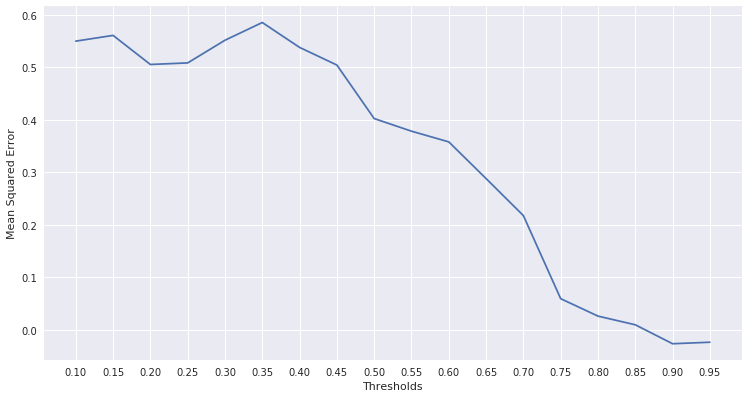

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.ylabel("Mean Squared Error")
plt.xlabel("Thresholds")
plt.xticks(r)
plt.plot(r,f)
#plt.axhline(y=error, color='r', linestyle='-');

In [23]:
R2, MSE, average_betweennes, average_shortest_path_length, error, null_r2 = cf.model(data,"LR","normal", lag=400)

data_deseasonal= cf.deseasonal_STL(data)
R2_ds, MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, error_ds, null_r2_ds = cf.model(data_deseasonal,"LR","normal",lag=400)

data_deseasonal_monthly= cf.deseasonal_monthly_anomaly(data)
R2_dsm, MSE_dsm, average_betweennes_dsm, average_shortest_path_length_dsm, error_dsm, null_r2_dsm = cf.model(data_deseasonal_monthly,"LR","normal",lag=400)


In [24]:
trace0 = go.Scatter(
    x = r,
    y = R2,
    name = 'R2 of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = R2_ds,
    name = 'R2 of STL deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = R2_dsm,
    name = 'R2 of monthly deseasonal data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

d = [trace0, trace1, trace2]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'R-squared',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
                            shapes = [
        {
            'type': 'line',
            'x0': 0.35,
            'y0': 0,
            'x1': 0.35,
            'y1': 1,
            'line': {
                'color': 'rgb(0, 0, 0)',
                'width': 0.5,
            },
        }]
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [28]:
trace0 = go.Scatter(
    x = r,
    y = average_shortest_path_length,
    name = 'Average Shortest Path of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2)
)
trace1 = go.Scatter(
    x = r,
    y = average_shortest_path_length_ds,
    name = 'Average Shortest Path of deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,)
)    
d = [trace0, trace1]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              xaxis = dict(title = 'Thresholds'),
              yaxis = dict(title = 'Average Shortest Path'),
              shapes = [
        {
            'type': 'line',
            'x0': 0.35,
            'y0': 0,
            'x1': 0.35,
            'y1': 3.5,
            'line': {
                'color': 'rgb(0, 0, 0)',
                'width': 0.5,
            },
        }]
              )

fig = dict(data=d, layout=layout)s
py.iplot(fig, filename='styled-line')

In [14]:
trace0 = go.Scatter(
    x = r,
    y = average_betweennes,
    name = 'Average Betweennes of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2)
)
trace1 = go.Scatter(
    x = r,
    y = average_betweennes_ds,
    name = 'Average Betweennes of deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,)
)    
d = [trace0, trace1]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              xaxis = dict(title = 'Thresholds'),
              yaxis = dict(title = 'Average Betweennes'),
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [19]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [20]:
R2, MSE, average_betweennes, average_shortest_path_length, error, null_r2 = cf.model(data,"NN","normal")

data_deseasonal= cf.deseasonal_STL(data)
R2_ds, MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, error_ds, null_r2_ds = cf.model(data_deseasonal,"NN","normal")

data_deseasonal_monthly= cf.deseasonal_monthly_anomaly(data)
R2_dsm, MSE_dsm, average_betweennes_dsm, average_shortest_path_length_dsm, error_dsm, null_r2_dsm = cf.model(data_deseasonal_monthly,"NN","normal")


In [21]:
trace0 = go.Scatter(
    x = r,
    y = R2,
    name = 'R2 of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = R2_ds,
    name = 'R2 of STL deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = R2_dsm,
    name = 'R2 of monthly deseasonal data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

d = [trace0, trace1, trace2]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'R-squared',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [22]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [23]:
R2, MSE, average_betweennes, average_shortest_path_length, error, null_r2 = cf.model(data,"RF","normal")

data_deseasonal= cf.deseasonal_STL(data)
R2_ds, MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, error_ds, null_r2_ds = cf.model(data_deseasonal,"RF","normal")

data_deseasonal_monthly= cf.deseasonal_monthly_anomaly(data)
R2_dsm, MSE_dsm, average_betweennes_dsm, average_shortest_path_length_dsm, error_dsm, null_r2_dsm = cf.model(data_deseasonal_monthly,"RF","normal")

In [24]:
trace0 = go.Scatter(
    x = r,
    y = R2,
    name = 'R2 of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = R2_ds,
    name = 'R2 of STL deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = R2_dsm,
    name = 'R2 of monthly deseasonal data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

d = [trace0, trace1, trace2]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'R-squared',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [5]:
r = np.arange(0.1,1,0.05)
df = cf.feature_importance(data)

In [9]:
trace0 = go.Scatter(
    x = r,
    y = df['degree'],
    name = 'degree',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
    dash = 'solid')
)
 
trace2 = go.Scatter(
    x = r,
    y = df['closseness'],
    name = 'closseness',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = df['kcore'],
    name = 'kcore',
    line = dict(
        color = ('rgb(202, 125, 68)'),
        width = 4,
        dash = 'dot')
)
trace4 = go.Scatter(
    x = r,
    y = df['betweeness'],
    name = 'betweeness',
    line = dict(
        color = ('rgb(105, 184, 68)'),
        width = 4,
        dash = 'dashdot')
)
trace5 = go.Scatter(
    x = r,
    y = df['pagerank'],
    name = 'pagerank',
    line = dict(
        color = ('rgb(3, 1, 5)'),
        width = 4,
        dash = 'longdashdot')
)
trace6 = go.Scatter(
    x = r,
    y = df['eigenvector'],
    name = 'eigenvector',
    line = dict(
        color = ('rgb(239, 38, 205)'),
        width = 4,
        dash = 'longdash')
)
trace7 = go.Scatter(
    x = r,
    y = df['clustering'],
    name = 'clustering',
    line = dict(
        color = ('rgb(248, 215, 34)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace2, trace3, trace4, trace5, trace6, trace7]

layout = dict(title = 'Features Importance based on Random Forest',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Importance',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [10]:
data_deseasonal= cf.deseasonal_STL(data)
df = cf.feature_importance(data_deseasonal)

trace0 = go.Scatter(
    x = r,
    y = df['degree'],
    name = 'degree',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
    dash = 'solid')
)
 
trace2 = go.Scatter(
    x = r,
    y = df['closseness'],
    name = 'closseness',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = df['kcore'],
    name = 'kcore',
    line = dict(
        color = ('rgb(202, 125, 68)'),
        width = 4,
        dash = 'dot')
)
trace4 = go.Scatter(
    x = r,
    y = df['betweeness'],
    name = 'betweeness',
    line = dict(
        color = ('rgb(105, 184, 68)'),
        width = 4,
        dash = 'dashdot')
)
trace5 = go.Scatter(
    x = r,
    y = df['pagerank'],
    name = 'pagerank',
    line = dict(
        color = ('rgb(3, 1, 5)'),
        width = 4,
        dash = 'longdashdot')
)
trace6 = go.Scatter(
    x = r,
    y = df['eigenvector'],
    name = 'eigenvector',
    line = dict(
        color = ('rgb(239, 38, 205)'),
        width = 4,
        dash = 'longdash')
)
trace7 = go.Scatter(
    x = r,
    y = df['clustering'],
    name = 'clustering',
    line = dict(
        color = ('rgb(248, 215, 34)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace2, trace3, trace4, trace5, trace6, trace7]

layout = dict(title = 'Features Importance based on Random Forest',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Importance',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [8]:
trace = go.Scatter(
    x = r,
    y = MSE
)

data = [trace]
layout = {}
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='line-mode')